# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from ddpg_agent import Agent
import random
import os
import torch
import matplotlib.pyplot as plt
# import requests, zipfile, io
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="/home/sayantani.bhattacharya/Desktop/Navigation-Proj/Value-based-methods/p2_continuous-control/Reacher_Linux/Reacher_Linux/Reacher.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. DDPG Agent Function

In [5]:
def ddpg(env, agent, n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    avg_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  # current states
        agent.reset()
        # score = np.zeros(1)
        score = np.zeros(agent.num_agents)
        for t in range(max_t):
            actions = agent.act(states)            
            env_info = env.step(actions)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     
            rewards = env_info.rewards                     
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break 

        episode_score = np.mean(score)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        avg_score = np.mean(scores_deque)
        avg_scores.append(avg_score)         
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score), end='')

        
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')  
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        # train till the target score
        target_score = 30
        if avg_score >= target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            break
        

        if i_episode % print_every == 0:
            
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            
    return scores

### 4. Plotting Function

In [6]:
# Plotting Function

def plot(scores):
    # Plot the Score evolution during the training
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='deepskyblue')
    ax.tick_params(axis='y', colors='deepskyblue')
    plt.plot(np.arange(1, len(scores)+1), scores, color='deepskyblue')
    plt.ylabel('Score', color='deepskyblue')
    plt.xlabel('Episode #', color='deepskyblue')
    plt.show()

### 5. Training ddpg and plotting scores.

Episode 100	Average Score: 25.57
Episode 113	Average Score: 30.06
Environment solved in 113 episodes!	Average Score: 30.06


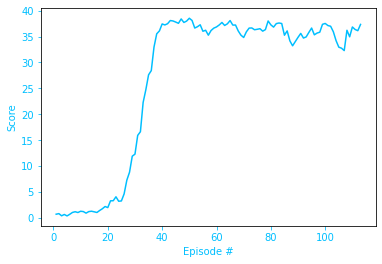

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents= num_agents, random_seed=2)

scores = ddpg(env, agent,1000,1000,100) 
plot(scores)

When finished, you can close the environment.

In [9]:
env.close()